In [1]:
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic' #window
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['axes.unicode_minus'] = False #한글 사용할 때 마이너스 기호 깨지는것을 해결

# 11.1 그레디언트 소실과 폭주 문제

- **그레이디언트 소실(vanishing gradient)**: 알고리즘이 하위층으로 진행될수록 그레이디언트가 점점 작아지는 경우(좋은 솔루션을 찾지못함)
<br><br>
- **그레이디언트 폭주(exploding gradient)**: 하위층으로 진행될수록 그레이디언트가 점점 커져 알고리즘이 발산하는 경우.(주로 RNN 계열에서 나타남)

In [3]:
def logit(z): 
    return 1 / (1 + np.exp(-z)) #로지스틱 활성화함수

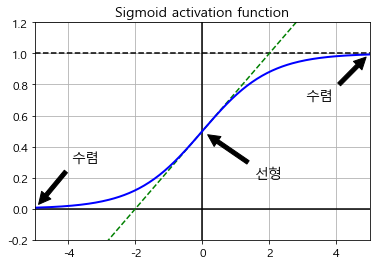

In [4]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
#plt.annotate() : 주석 달기
    #xytext = (): text 위치 default는 xy
    #xy= (): point 위치
    #arrowprops: 화살표 모양을 설정하기 위한 매개변수
        #매개변수의 값을 dict 형식으로 해서 넣어줌
plt.annotate('수렴', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('수렴', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('선형', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

#save_fig("sigmoid_saturation_plot")
plt.show()

#### 그라이디언트를 불안정하게 만드는 원인
- 로지스틱 시그모이드 활성화 함수와 가중치 초기화 방법(표준정규분포를 따르게)의 조합.
    - 신경망의 높은 층에서 활성화 함수가 0이나 1로 수렴.
    - 위 그래프에서 볼 수 있듯이, 활성화 함수가 0이나 1의 값이 나온다는것은 **기울기가 0에 매우 가까워 진다**는 뜻이다.

## 11.1 글로럿과 He 초기화
- 세이비어 글로럿의 해결 방법(시그모이드 활성화 함수에 대한 가중치 초기화 = **세이비어 초기화**)
    1. 각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야 한다. 
    2. 역방향에서 층을 통과하기 전과 후의 그레이디언트의 분산이 동일해야 한다.
        - fan in: 게이트에 연결될 수 있는 최대 입력수.(호출 하는, 나가는?)
        - fan out: 게이트의 출력에 연결될 수 있는 입력게이트의 최대 수.(호출 되는, 들어오는?) [출처](https://thegap.tistory.com/387)
    <br><br>
    - 즉, 각 층의 연결 가중치를 아래와 같은 방식으로 초기화 한다.
        - 평균이 0이고 분산이 $\sigma^2 = {1\over{fan_{avg}}}$인 정규분포(**Xavier Normal initialization**)
        - 또는 $r = \sqrt{3\over{fan_{avg}}}$일 때 $-r$과 $+r$사이의 균등 분포(**Xavier Uniform initialization**)
<br><br>
- 위 식에서 $fan_{avg}$를 $fan_{in}$으로 바꾸면 **르쿤(LuCun) 초기화**가 된다.
    - 만약 $fan_{avg} = fan_{in}$이면 **르쿤 초기화 == 글로럿 초기화**
---
- ReLU 활성화 함수에 대한 가중치 초기화는 **He 초기화**
    - He 초기화도 Normal, Uniform 2가지가 존재함.
---
|초기화 전략|활성화 함수|정규분포|
|:---|:---:|:---:|
|글로럿|활성화 함수 없음 or 하이퍼볼릭 탄젠트, 로지스틱, 소프트맥스|$1\over fan_{avg}$|
|He|ReLU 함수와 그 변종들|$2\over fan_{in}$|
|르쿤|SELU|$1\over fan_{in}$|

In [5]:
#케라스에 존재하는 가중치 초기화 모듈 확인
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [6]:
#기본적으로 He 초기화를 지원하기 때문에, initializer = "he_normal"로 해주면 됨
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [7]:
#fan_avg기반의 균등 분포 HE 초기화를 사용하고 싶다면
    #VarianScaling을 사용하면 된다
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## 11.1.2 수렴하지 않는 활성화 함수
- 활성화 함수를 잘못 선택하면 vanishing gradient나 exploding gradient
    - 로지스틱 시그모이드 이외에도 더 잘 작동하는 활성화 함수가 있음을 발견 ~ 대표적으로 **ReLU**
##### ReLU 함수의 문제점: dying ReLU
- 일부 뉴런이 0이외의 값을 출력하지 않는 경우가 있음.(죽은 상태)
    - 특히 학습률이 큰 경우 신경망의 많은 뉴런이 죽을 수도..
    - 가중치 합이 음수면 ReLU의 gradient가 0이 되므로 경사 하강법이 작동하지 않음
---
##### ReLU 문제를 해결하기 위한  함수들
1. LeakyReLU
    - 일반적으로 LeakyReLU가 항상 ReLU보다 성능이 좋음.
    - $LeakyReLU_{\alpha}(z) = \max(\alpha z, z)$ 
        - $\alpha$: 새는 정도. 하이퍼파라미터.
        - 새는 정도란 z < 0일 때 이 함수의 기울기가 된다. 이것이 LeakyReLU를 절대 죽지 않게 만들어준다.
<br><br>
2. RReLU(randomized leaky ReLU)
    - 훈련하는 동안 주어진 범위에서 $\alpha$를 무작위로 선택하고 테스트 시에 평균을 사용
<br><br>
3. PReLU(parametic leaky ReLU)
    -  $\alpha$가 훈련하는 동안 학습된다.
    - 소규모 데이터에서는 과대적합 위험
<br><br>
4. ELU(Exponential linear unit)
    - $ELU_\alpha(z) = 	\begin{cases}
    \alpha(\exp(z)- 1) \space z<0 일 때\\
    z \space\space\space z \ge 0 일때\\
  \end{cases} $
      - z < 0 일 때 음숫값 => 기울기 소실 문제 완화.
      - z < 0 이어도 그레디언트가 0이 아님
      - $\alpha$ = 1이면 z = 0에서 급격히 변동 x($\alpha$가 1이 아니면 도함수는 z= 0에서 불연속)
      - 속도가 느릴수도(지수함수 계산)
<br><br>
5. SELU(scaled ELU)
    - 스케일이 조정된 ELU 활성화 함수
    - 신경망이 모두 완전연결이고, 모든 은닉층이 SELU를 쓴다면 네트워크는 self-normalize된다.(훈련 중에는 출력이 평균 0과 표준편차 1을 유지한다)
    - Self-normalize 되기 위한 조건
        1. 입력 특성이 표준화 되어야 함.(평균0, 표준편차 1)
        2. 모든 은닉층의 가중치가 르쿤 정규분포 초기화로 초기화 되어야 함.
        3. 네트워크는 일렬로 쌓은 층이어야 한다.(모두 완전 연결층)

##### LeakyReLU

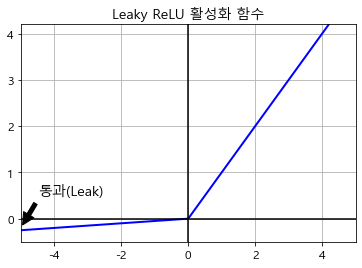

In [8]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('통과(Leak)', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU 활성화 함수", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

#### ELU

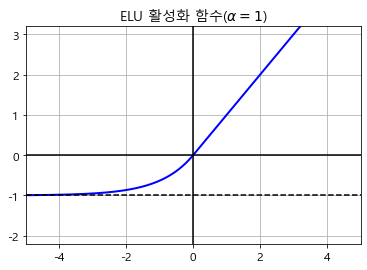

In [9]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU 활성화 함수($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

#### LeakyReLU를 테스트

In [10]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [11]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [12]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

import time

start_time = time.time()

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
print("소요 시간: {}".format(float(time.time()- start_time)))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7955 - accuracy: 0.7362 - val_loss: 0.7130 - val_accuracy: 0.7658
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7896
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5832 - accuracy: 0.8075 - val_loss: 0.5582 - val_accuracy: 0.8202
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5553 - accuracy: 0.8157 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5338 - accuracy: 0.8225 - val_loss: 0.5157 - val_accuracy:

#### PReLU 테스트

In [13]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

strat_time = time.time()
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
print("소요 시간: {}".format(float(time.time()- start_time)))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7630
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6966 - accuracy: 0.7694 - val_loss: 0.6564 - val_accuracy: 0.7884
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6331 - accuracy: 0.7910 - val_loss: 0.6003 - val_accuracy: 0.8048
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5917 - accuracy: 0.8057 - val_loss: 0.5656 - val_accuracy: 0.8182
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5618 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5390 - accuracy: 0.8205 - val_loss: 0.5196 - val_accuracy:

#### SELU 그래프로 확인

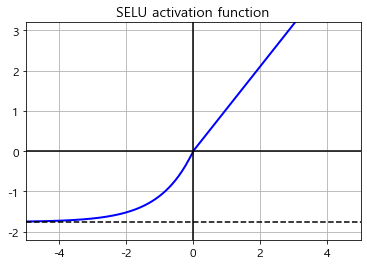

In [14]:
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화합니다
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])


plt.show()



## 11.1.3 배치 정규화(Batch normalization)

활성화 함수를 통과하기 전이나 후에 연산을 추가.( + 파라미터 2개 추가)  
- 입력을 원점에 맞추고 정규화 & 새로운 파라미터 2개로 결괏값의 스케일을 조정하고 이동. [자세한 설명 by hukkpen](https://www.youtube.com/watch?v=m61OSJfxL0U&t=642s)
1. $u_B = {1\over m_B}\sum_{i=1}^{m_B}x^{(i)}$
<br><br>
2. $\sigma^2 = {1\over m_B}\sum_{i=1}^{m_B}(x^{(i)}u_B)^2$
<br><br>
3. $\hat x^{(i)} = {x^{(i)} - u_B \over \sqrt{\sigma^2_B} + \epsilon}$
<br><br>
4. $z^{(i)} = \gamma \otimes \hat x^{(i)} + \beta$
    - $u_B$: 미니배치 B에 대해 평가한 입력의 평균 벡터
    - $\sigma_B$: 미니배치에 대해 평가한 입력의 표준편차 벡터
    - $m_B$: 미니배치에 있는 샘플 수
    - $\hat x^{(i)}$: 평균이 0이고 정규화된 샘플 $i$의 입력
    - $\gamma$: 층의 출력 스케일 파라미터
        - $\gamma$ 와 $\beta$의 차원은 모두 $z^{(i)}$와 같음!
    - $\otimes$: 원소별 곱셈
    - $\beta$: 층의 출력 이동 파라미터 벡터.
    - $\epsilon$: 분모가 0이 되는 것을 막음.**안전을 위한 항(smoothing term)**
    - $z^{(i)}$: 배치 정규화 연산의 출력
---
- iid(independent and identically distributed)
    - 2개 이상의 확률변수를 함께 고려할 때 이들의 확률적 특성이
    1. 통계적으로 독립이며
    2. 동일한 확률분포를 가지고 있다는 것을 말한다.(분포가 같다)

In [15]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.summary()
#첫번째 batchnormalization에서 파라미터 개수는 3136개 = 784 * 4
    #4개 중에는 학습되지 않는 파라미터 2개가 있음(이동 평균, 이동분산)

    #마지막에 나오는 non-trainable의 개수는
        #배치 정규화 층 3개 3136 + 1200 + 400 = 4736
        #4736/2 = 2368

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_8 (Dense)             (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

In [17]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]
#이동 평균과 이동 분산은 학습되지 않는 것을 확인(False)

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [18]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.8293 - accuracy: 0.7221 - val_loss: 0.5539 - val_accuracy: 0.8160
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5703 - accuracy: 0.8036 - val_loss: 0.4792 - val_accuracy: 0.8382
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5161 - accuracy: 0.8212 - val_loss: 0.4425 - val_accuracy: 0.8490
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4789 - accuracy: 0.8313 - val_loss: 0.4212 - val_accuracy: 0.8572
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4548 - accuracy: 0.8407 - val_loss: 0.4051 - val_accuracy: 0.8618
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4387 - accuracy: 0.8444 - val_loss: 0.3931 - val_accuracy: 0.8634
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4254 - accuracy: 0.8501 - val_loss: 0.3829 - val_accuracy:

## 11.1.4 그레이디언트 클리핑(gradient clipping)
- 역전파될 때 일정 임계값을 넘어서지 못하게 그레이디언트를 잘라내자
- ```clipnor```또는 ```clipvalue```를 사용

In [19]:
optimizer = keras.optimizers.SGD(clipvalue=1.0) 
#그레이디언트 벡터의 모든 원소를 -1.0 과 1.0사이로 클리핑한다.
    #벡터의 원소 범위를 바꿈으로써 벡터의 방향을 바꿀 수 있음!
        #예를 들어 [0.9, 100] -> [0.9, 1.0] 방향이 바뀌죠?
        

model.compile(loss = 'mse', optimizer = optimizer)

- 방향을 바꾸지 못하게 하려면 ```clipnorm```을 사용해야 한다.
    - ```clipnorm = 1.0```으로 한다면,,,
        - [0.9, 100] -> [0.00899964, 0.9999595] 
        - 결국 방향은 바뀌지 않게 됨!(근데 첫번째 원소 값은 거의 무시된다)

# 11.2 사전 훈련된 층 사용하기
#### 전이학습(Transfer learning)
- 아주 큰 규모의 DNN을 처음부터 학습시키는 것은 비효율적임.
    - 비슷한 유형의 문제를 잘 처리하는 신경망을 가져와서 하위층을 재사용하자
    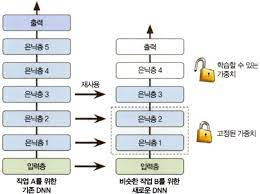
    <br><br>
일반적으로 원본 모델의 상위 은닉층은 하위 은닉층보다 덜 유용하다. 따라서 재사용할 층의 개수를 잘 선정해야함!
- **작업이 비슷할수록 많은 층을 재사용 하는 것이 좋음.**
    - 완전 비슷? => 출력층만 교체!
---
메커니즘
1. 재사용 할 층을 동결(학습되지 않게 고정)
2. 모델 훈련하고 성능 평가
3. 가장 상위의 은닉층의 동결 해제하고 학습시켜 가중치 조정  
    - 성능이 향상 되는지 확인해보기
4. 향상되지 않는다면 그 은닉층들 제거 -> 남은 은닉층에서 3단계를 재수행.
5. 적절한 은닉층의 개수를 찾을 때까지 3-4를 반복 

## 11.2.1 케라스를 사용한 전이 학습
- 8개의 클래스를 분류하는 모델A
    - 그 중에서 2개의 클래스만 구분하는 모델 B
    - 모델 A와 모델 B의 작업, 구조 모두 비슷하니까 모델 A를 가져와 써보자

In [20]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A), (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [21]:
X_train_A.shape

(43986, 28, 28)

In [22]:
X_train_B.shape

(200, 28, 28)

In [23]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [24]:
tf.random.set_seed(42)
np.random.seed(42)

model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))

for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
    
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [25]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [26]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.5926 - accuracy: 0.8103 - val_loss: 0.3894 - val_accuracy: 0.8670
Epoch 2/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3523 - accuracy: 0.8786 - val_loss: 0.3290 - val_accuracy: 0.8817
Epoch 3/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.3170 - accuracy: 0.8896 - val_loss: 0.3013 - val_accuracy: 0.8994
Epoch 4/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2973 - accuracy: 0.8975 - val_loss: 0.2893 - val_accuracy: 0.9021
Epoch 5/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2834 - accuracy: 0.9020 - val_loss: 0.2773 - val_accuracy: 0.9058
Epoch 6/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2729 - accuracy: 0.9062 - val_loss: 0.2733 - val_accuracy: 0.9071
Epoch 7/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2641 - accuracy: 0.9092 - val_loss: 0.2722 - val_accuracy:

In [27]:
model_A.save("my_model_A.h5") #model A를 저장!

In [28]:
#다시 불러오기
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1]) #마지막 층 빼고 가져오기
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid")) #이진분류임

In [29]:
#model_B_on_A를 훈련할 때 model_A도 영향을 받기 때문에 model_A를 복사해놓자
    #두 모델이 층을 공유하기 때문에 영향을 받는다...
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

- 그냥 학습을 돌려버리면 오차가 너무 커져서 가중치가 이상하게 조정될 수 있음.
    - 따라서 학습이 안되게 동결시켜놓고, epoch을 조금 돌린 다음
    - 동결을 풀고 제대로 학습을 진행
        - **주의**: 층을 동결/해제 하고 나서 항상 모델을 compile해야함!

In [30]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False #학습이 안되게 동결!

    #동결하고 나서 컴파일!
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

#에폭 돌리기(학습은 안됨)
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 60ms/step - loss: 2.1994 - accuracy: 0.1250 - val_loss: 2.0725 - val_accuracy: 0.1907
Epoch 2/4
7/7 [==============================] - 0s 17ms/step - loss: 2.0212 - accuracy: 0.1600 - val_loss: 1.9207 - val_accuracy: 0.2221
Epoch 3/4
7/7 [==============================] - 0s 15ms/step - loss: 1.8624 - accuracy: 0.2000 - val_loss: 1.7766 - val_accuracy: 0.2566
Epoch 4/4
7/7 [==============================] - 0s 15ms/step - loss: 1.7122 - accuracy: 0.2250 - val_loss: 1.6398 - val_accuracy: 0.2890


In [31]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True#동결 해제
    
#동결 해제 후에는 무조건 compile을 해줘야함!
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 1s 60ms/step - loss: 1.2177 - accuracy: 0.3400 - val_loss: 0.7676 - val_accuracy: 0.4787
Epoch 2/16
7/7 [==============================] - 0s 19ms/step - loss: 0.6176 - accuracy: 0.6050 - val_loss: 0.5256 - val_accuracy: 0.7069
Epoch 3/16
7/7 [==============================] - 0s 19ms/step - loss: 0.4193 - accuracy: 0.8000 - val_loss: 0.3892 - val_accuracy: 0.8499
Epoch 4/16
7/7 [==============================] - 0s 19ms/step - loss: 0.3084 - accuracy: 0.9250 - val_loss: 0.3079 - val_accuracy: 0.9097
Epoch 5/16
7/7 [==============================] - 0s 20ms/step - loss: 0.2410 - accuracy: 0.9450 - val_loss: 0.2544 - val_accuracy: 0.9310
Epoch 6/16
7/7 [==============================] - 0s 21ms/step - loss: 0.1961 - accuracy: 0.9700 - val_loss: 0.2189 - val_accuracy: 0.9452
Epoch 7/16
7/7 [==============================] - 0s 22ms/step - loss: 0.1665 - accuracy: 0.9700 - val_loss: 0.1929 - val_accuracy: 0.9564
Epoch 8/16
7/7 [===========

In [32]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.0985 - accuracy: 0.9810


[0.09846139699220657, 0.9810000061988831]

- 전이학습은 조금 더 일반적인 특성을 감지하는 경향이 있는 심층 합성곱 신경망에서 잘 작동한다.
    - 전이 학습은 **작은 완전 연결 네트워크**에서는 잘 작동하지 않는다.

## 11.2.2 비지도 사전훈련
- 레이블된 훈련 데이터가 많이 없을 때 => **비지도 사전훈련(unsupervised pretraining)**을 수행!
    1. 레이블되지 않는 데이터를 많이 모아서 AE(autoencoder)나 GAN과 같은 비지도 학습 모델 훈련
    2. AE나 GAN 판별자의 하위층을 재사용 -> 그 위에 새로운 출력층 추가
    3. 지도학습으로 최종 네트워크 fine tuning
---
옛날에는 ```RBM(restricted Boltzmann machine)```을 사용했는데 요즘은 ```AE```나 ```GAN```을 더 많이 사용함. 방법도 훨씬 간단해졌다.  
- 전체 비지도 모델 학습 후 지도 학습 기법으로 레이블된 데이터에 대한 최종 학습을 진행

## 11.2.3 보조 작업에서 사전 훈련
- 레이블된 훈련 데이터를 생성할 수 있는 보조 작업에서 첫 번째 신경망을 훈련.
    - 이 신경망의 하위층을 실제 작업을 위해 재사용.(특성 추출기로 사용)
<br><br>
- 에를 들어, 얼굴 인식 시스템
    - 개인별 사진 모으기 힘듬(레이블된 훈련 데이터 모으기 힘들다)
    - 인터넷에서 무작위로 많은 인물 수집해서 두 이미지가 같은지 다른지 판별하는 첫 번째 신경망을 훈련.(특성을 감지하는 신경망)
    - 이 신경망의 하위층을 재사용하여 적은 훈련 데이터에서 얼굴을 구분하는 분류기 훈련 가능!
---
- **참고**: 자기 지도 학습(self-supervised learning)은 데이터에서 스스로 레이블을 생성하고 지도 학습 기법으로 레이블된 데이터셋에서 모델을 훈련.(비지도 학습에 속한다)


지금까지 훈련 속도를 높이는 방법이었다.(초기화 전략, 활성화 함수, BN, 전이학습)  
거기에 좋은 ```옵티마이저```를 사용하면 속도를 더욱 높일 수 있다!

---
# 11.3 고속 옵티마이저
## 11.3.1 모멘텀 최적화
- 볼링공이 종단속도에 도달할 때까지는 빠르게 가속된다 <<<< ```모멘텀 최적화의 원리```<br><br>
- 모멘텀 알고리즘
    1. $m \leftarrow \beta m - \eta \nabla_{\theta}J(\theta)$
        - $J(\theta)$: 가중치에 대한 비용함수
        - $m$: 모멘텀 벡터
        - $\beta$: 모멘텀 ~ 0과 1사이의 값(일반적으로 0.9로 설정)
    2. $\theta \leftarrow \theta + m$
    - 모멘텀 값을 이용하기 때문에 일반적인 경사하강법보다 속도가 빠를 수 밖에 없다.
    - 또한 local optima를 건너뛰도록 하는데 도움이 된다.
<br>

In [33]:
#모멘텀 옵티마이저
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

## 11.3.2 네스테로프 가속 경사(NAG)
- 모멘텀 최적화의 변종.
    - 거의 항상 모멘텀 최적화보다 빠르다. 
    - 현재 위치가 모멘텀의 방향으로 조금 앞선 $\theta + \beta m$에서 비용함수의 그레이디언트를 계산
- 네스테로프 가속 경사 알고리즘
    1. $m \leftarrow \beta m - \eta \nabla_{\theta}J(\theta + \beta m)$
    2. $\theta \leftarrow \theta + m$

In [34]:
#네스테로프 가속 경사
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

## 11.3.3 AdaGrad
- 가장 가파른 차원을 따라 그레이디언트 벡터의 스케일을 감소시켜 전역 최적점 쪽으로 더 정확한 방향을 잡을 수 있다.
- AdaGrad 알고리즘
    1. $s \leftarrow s + \nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta)$
    2. $\theta \leftarrow \theta - \eta\nabla_\theta J(\theta)  \oslash \sqrt{s + \epsilon}$
    <br><br>
    - 벡터 $s$의 각 원소 $s_i$는 파라미터 $\theta_i$에 대한 비용 함수의 편미분을 제곱하여 누적한다.
        - 비용 함수가 $i$번째 차원을 따라 가파르다면 $s_i$는 반복될 때마다 커질 것이다.
    - 두번째 단계에서는 그레이디언트 벡터를 $\sqrt{s + \epsilon}$으로 나누어 스케일을 조정한다.(원소별 나눗셈)
    - **적응적 학습률**: 학습률을 감소시키지만 경사가 완만한 차원보다 가파른 차원에 대해 더 빠르게 감소된다. 
---
```AdaGrad```는 신경망을 훈련할 때 일찍 멈추는 경우가 있다.  
- 학습률이 너무 감소하여 global optima에 도달하지 못함.
    - 그래서 **심층 신경망에는 사용하면 안됨**

In [35]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

## 11.3.4 RMSProp
- 가장 최근 반복에서 비롯된 레이디언트만 누적함으로써 전역 최적점에 수렴할 수 있게 하는 알고리즘.
    - 지수 감소를 사용한다. 
---
- RMSProp 알고리즘
    1. $s \leftarrow \beta s + (1-\beta)\nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta)$
    2. $\theta \leftarrow \theta - \eta\nabla_\theta J(\theta)  \oslash \sqrt{s + \epsilon}$
        - $\beta$: 감쇠율(보통 0.9로 설정)

In [36]:
#RMSProp
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
                    #rho는 RMSProp의 beta에 해당한다

## 11.3.5 Adam과 Nadam 최적화
- **Adam**: adaptive moment estimation(적응적 모멘트 추정)
    - 모멘텀 최적화와 RMSProp의 아이디어를 합쳤다.
---
- Adam 알고리즘
    1. $m \leftarrow \beta_1 m - (1-\beta_1)\nabla_{\theta}J(\theta)$
    <br><br>
    2. $s \leftarrow \beta_2 s + (1-\beta_2)\nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta)$
    <br><br>
    3. $\hat m \leftarrow {m \over 1-\beta_1^t}$
    <br><br>
    4. $\hat s \leftarrow {s \over 1-\beta_2^t}$
    <br><br>
    5. $\theta \leftarrow \theta + \eta \hat m \oslash \sqrt{\hat s + \epsilon}$
---
- 지수 감소 평균을 사용 
    - 지수감소 평균,,? 지수 감소 합,,?
    

In [37]:
#Adam
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

##### Adam의 두 가지 변종
1. AdaMax
    
2. Nadam
---
논의한 모든 최적화 기법은 ```1차 편미분(야코비안)```에만 의존한다.  
- ```2차 편미분(헤시안)```을 심층 신경망에 적용하기는 힘들다.
    - 출력마다 $n^2$개의 2차 편미분을 실시 $\rightarrow$ 메모리 용량을 넘어서거나 시간이 엄청 오래걸리는 경우가 많음.
---
##### 모든 Optimizer 비교
|클래스|수렴 속도|수렴 품질|
|:---|:---|:---|
|SGD|나쁨|좋음|
|SGD(모멘텀 최적화)|보통|좋음|
|SGD(네스테로프)|보통|좋음|
|AdaGrad|좋음|나쁨(너무 빨리 멈춤)|
|RMSProp|좋음|보통 또는 좋음|
|Adam|좋음|보통 또는 좋음|
|Nadam|좋음|보통 또는 좋음|
|AdaMax|좋음|보통 또는 좋음|


## 11.3.6 학습률 스케줄링
- 좋은 학습률 찾기
    1. 매우 작은 값에서 매우 큰 값까지 지수적으로 학습률을 증가시키면서 모델 훈련을 반복하여 최적의 학습률 찾기.(고정 학습률)
    2. **큰 학습률로 시작하고 학습속도가 느려질 때 학습률을 낮추기**
        - 즉, 학습률을 변화시키면서 학습 = **학습 스케쥴링(learning schedule)**
---
#### 1. 거듭제곱 기반 스케줄링(power scheduling)
- 학습률을 반복횟수 $t$에 대한 함수 $\eta(t) = \eta_0 \space / \space (1+t/s)^c$ 로 지정. 
    - $\eta_0$: 초기 학습률.
    - $c$: 거듭제곱 수(일반적으로 1로 설정)
    - $s$: 스텝 횟수.(하이퍼파라미터)
    - 처음에는 빠르게 감소  (${1\over 2}, {1\over3},...$)하다가 점점 느리게 감소
---
#### 2. 지수 기반 스케줄링(exponential scheduling)
- 학습률을 $\eta(t) = \eta_00.1^{t\over s}$로 설정
    - $s$ 스텝마다 10배씩 점차 줄어들게 된다. 
----
#### 3. 구간별 고정  스케줄링(piece constant scheduling)
- 일정 횟수의 에포크 동안 일정한 학습률 사용.
    - 그 다음 또 다른 횟수의 에포크 동안 작은 학습률 사용
    <br><br>
    - 예를 들어, 5에포크 동안 학습률 0.1 그 다음 50 에포크 동안 학습률 0.001
---
#### 4. 성능 기반 스케줄링(performance scheduling)
- 매 $N$스텝마다 (조기 종료처럼) 검증 오차를 측정하고 오차가 줄어들지 않으면 $\lambda$배 만큼 학습률을 감소시킴
---
#### 5. 1사이클 스케줄링(1cycle scheduling)
- 절반동안 초기 학습률을 선형적으로 **증가**시킴!?
    - 나머지 절반동안 선형적으로 **감소**시킴(초기 학습률에 도달할 때까지)
    - 마지막 몇 번의 에포크에서는 소수점 몇 째자리까지 줄임(선형적으로)

In [38]:
# 거듭제곱 기반 스케줄링(케라스에서 가장 구현하기 쉽다)
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)
    #decay = 1 / s

In [39]:
# 지수기반 스케줄링
def exponential_decay_fn(epoch): #현재 epoch를 받아 
    return 0.01 * 0.1**(epoch / 20) #학습률을 return

#하드코딩 하고 싶지 않다면 클로저를 반환하는 함수?
    #하드코딩: 데이터를 코드 내부에 직접 입력하는 것이다
    #클로저: 내부 함수를 사용하여 값을 반환하는 건가,,,? 잘 모르겠다.
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [40]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds
#콜백 만들기
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.8467 - accuracy: 0.7546 - val_loss: 0.8116 - val_accuracy: 0.7468 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6988 - accuracy: 0.7869 - val_loss: 0.6939 - val_accuracy: 0.8062 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6545 - accuracy: 0.8062 - val_loss: 0.6567 - val_accuracy: 0.7974 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5702 - accuracy: 0.8214 - val_loss: 0.6328 - val_accuracy: 0.8246 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5437 - accuracy: 0.8336 - val_loss: 0.6274 - val_accuracy: 0.8266 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4959 - accuracy: 0.8471 - val_loss: 0.5113 - val_accuracy: 0.8476 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 7s

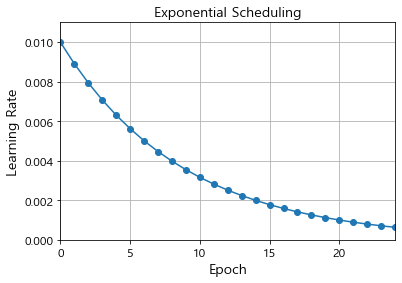

In [41]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [42]:
#이 스케줄 함수는 두 번째 매개변수로 현재 학습률을 받는다.
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)
    #이렇게하면 옵티마이저의 초기 학습률에만 의존하므로 이를 적절하게 설정해야함

##### 구간별 고정 스케줄링
- 모델을 저장할때는 옵티마이저와 학습률이 함께 저장된다.
    - 하지만 스케줄 함수가 epoch를 매개변수로 사용한다면, epoch는 따로 저장되지 않기 때문에 문제가 발생
    - 따라서 **저장한 epoch에서 시작하도록 ```initial_epcoh```매개변수를 수동 지정**

In [43]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

###### 성능 기반 스케줄링(```ReduceROnPlateau``` 사용)
- ```patience = 5```의미: 다섯 번의 연속적인 에포크동안 향상되지 않을 때 학습률에 ```factor```를 곱한다.

In [45]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience = 5)
#ReduceROnPlateau <<< 성능 기반 스케줄링
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5851 - accuracy: 0.8071 - val_loss: 0.4937 - val_accuracy: 0.8558 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4901 - accuracy: 0.8411 - val_loss: 0.5474 - val_accuracy: 0.8466 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5141 - accuracy: 0.8415 - val_loss: 0.4633 - val_accuracy: 0.8590 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5202 - accuracy: 0.8434 - val_loss: 0.4872 - val_accuracy: 0.8598 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5250 - accuracy: 0.8484 - val_loss: 0.5565 - val_accuracy: 0.8428 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4908 - accuracy: 0.8575 - val_loss: 0.5202 - val_accuracy: 0.8574 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 5s

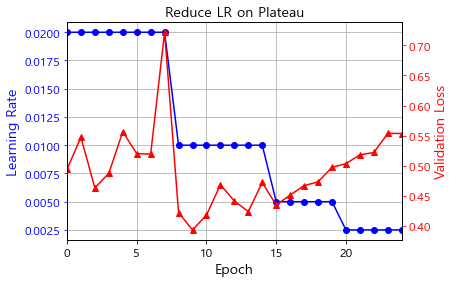

In [46]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

#### ```tf.keras``` 스케줄러
- ```keras.optimizers.schedules```에 있는 스케줄 중에 하나를 사용해 학습률을 정의 $\rightarrow$ 이 학습률을 Optimizer에 전달
    - 매 Step마다 학습률을 업데이트하게 된다.

In [48]:
s = 20 * len(X_train) // 32 #20번 epoch에 담긴 전체 스텝 수(32는 배치사이즈임)

learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)

#### 1사이클 스케줄링
- 매 반복마다 학습률을 조정하는 사용자 정의 콜백을 만들자
---
**결론적으로, 지수 기반, 성능 기반, 1사이클이 수렴 속도를 크게 높일 수 있다**

# 11.4 규제를 사용해 과대적합 피하기
## 11.4.1 $l_1$과 $l_2$규제

In [49]:
#규제강도 0.01을 적용한 l2 규제

layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

- ```l2()```함수는 훈련하는 동안 규제 손실을 계산하기 위해 각 스텝에서 호출되는 규제 객체를 반환
    - 이 손실은 최종 손실에 합산된다.
- l1과 l2규제 모두 필요하다면 ```keras.regularizes.l1_l2()```를 사용
---
##### 파이썬의 ```functools.partial()```함수를 사용하여 refactoring
- refactoring: 결과의 변경 없이 코드의 구조를 재조정하는 것.
<br><br>
- 모든 층에 동일한 규제를 적용하기 때문에 매개변수 값을 계속 반복해야함 => **refactoring** 사용
    - 코드를 읽기 쉽게 만들고, 버그를 피할 수 있음


In [50]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

## 11.4.2 드롭아웃(dropout)
- 매 훈련 스텝에서 각 뉴런은 임시적으로 드롭아웃될 확률 P를 가진다.(완전히 무시될 확률)
    - 보통 10%와 50% 사이를 지정.
    - 훈련이 끝나고는 드롭아웃 적용하지 않는다. 
    - 일반적으로 출력층을 제외한 맨 위의 층부터 세 번째 층까지 있는 뉴런에만 드롭아웃 적용.
<br><br>
- **기술적 세부사항**
    - $p$=50%로 하면 테스트 동안에는 하나의 뉴런이 훈련 때보다 (평균적으로)2배 많은 뉴런과 연결.
    - $\rightarrow$ 따라서 이 점을 보상하기 위해 훈련 후 각 뉴런의 연결 가중치에 $0.5$곱하기.
        - 이렇게 곱해지는 상수를 **보존 확률(keep probability)**라고 한다. 드롭아웃 비율이 $p$일 때 보존 확률은 **$(1-p)$**

In [52]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2), #드롭아웃 적용(p는 드롭아웃 비율)
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

- **조심**: 드롭아웃을 적용했을 때 train loss와 val loss를 비교하는 것은 오해를 일으키기 쉽다.
    - 훈련이 끝난 후에는 드롭아웃을 빼고 train loss를 평가해야 한다.
<br><br>
- 모델이 과대적합 되었다면 드롭아웃 비율 늘리기
- 모델이 과소적합 되었다면 드롭아웃 비율 낮추기
---
- 일반적으로 드롭아웃을 적용하면 수렴이 느려짐.

## 11.4.3 몬테 카를로 드롭아웃(MC 드롭아웃)
- 드롭아웃 네크워크를 훈련하는 것이 심층 가우스 과정이라 불리는 특정 확률 모델에서 근사 베이즈 추론과 수학적으로 동등하다.
- 드롭아웃 모델을 재훈련하거나 수정하지 않고 성능을 향상시킬 수 있는 기법이다. 모델의 불확실성을 더 잘 측정하고 구현이 쉽다.

In [53]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
#y_probas는 [100, 10000, 10]모양의 텐서.(10000 x 10 행렬 100개를 쌓았다)
    #training = True: 드롭아웃 층이 활성화??

y_proba = y_probas.mean(axis=0) #열을 따라서 평균을 계산
y_std = y_probas.std(axis=0) #열을 따라서 표준편차를 계산

In [65]:
arrays = np.array([np.random.randn(2, 2) for _ in range(10)])
#print(arrays)
#print(arrays.shape)
#print(np.stack(arrays, axis=0))
#print(np.stack(arrays, axis=0).shape)
#print(np.stack(arrays, axis=1))
#print(np.stack(arrays, axis=1).shape)
#print(np.stack(arrays, axis=2))
#print(np.stack(arrays, axis=2).shape)

In [66]:
np.round(model.predict(X_test_scaled[:1]), 2)
#책따라서 다시 훈련을 안하니까 이상한 값이 나오네ㅠ.ㅠ

1/1 [==============================] - 0s 150ms/step


array([[0.35, 0.13, 0.06, 0.2 , 0.02, 0.07, 0.02, 0.03, 0.05, 0.08]],
      dtype=float32)

In [67]:
#Dropout층을 MCDropout으로 바꾸기 ~
    #모델이 훈련하는 동안 (BN층과 같은)다르게 작동하는 층이 있다면
    #훈련모드를 강제로 설정하면 안됨ㅠ
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)
    #call()을 오버라이드
        #오버리아드: 상속받은 class에 속해있는 메서드를 무시하고 새로운 메서드를 만든다
            #기능이 같은 메서드 이름으로 계속 사용되어야할 때 활용

mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])
#isinstance(a, int)
    #a가 int인지 알아보기 위함  ~ 맞으면 True
    #여기서는 layer가 AlphaDropout이 적용되는지 확인

mc_model.summary()
    

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dropout_3 (Dropout)         (None, 784)               0         
                                                                 
 dense_32 (Dense)            (None, 300)               235500    
                                                                 
 dropout_4 (Dropout)         (None, 300)               0         
                                                                 
 dense_33 (Dense)            (None, 100)               30100     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_34 (Dense)            (None, 10)              

## 11.4.4 맥스-노름 규제(max-norm regularization)
- 각각의 뉴런에 대해 입력의 연결 가중치 $w$가 $||w||_2 \leq r$이 되도록 제한
    - $r$은 맥스-노름 하이퍼파라미터
    - $||\space \cdot \space||_2$는 l2노름
- 불안정한 그레이디언트 문제를 완화할 수 있다.
---
- 매 훈련 스텝이 끝나고 $||w||_2$를 계산하고, 필요하면 스케일도 조정
    - 스케일 조정
        - $w \leftarrow w{r \over {||w||_2}}$
        - $r$을 줄이면 규제 많이. 즉 **과대적합 감소**에 도움이 됨

In [69]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

#파이썬의 functools.partial()사용
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])

- 매 훈련 반복이 끝나면 ```fit()```메서드가 층의 가중치와 함께 ```max_norm()```이 반환한 객체를 호출하고 스케일이 조정된 가중치를 반환 받는다.

# 11.5 요약 및 실용적인 가이드라인
- **기본 DNN설정**(반드시 따라야 하는건 아님)
|하이퍼파라미터|기본값|
|:---|:---|
|커널 초기화|He 초기화|
|활성화 함수|ELU|
|정규화|얕은 신경망일 경우 없음. 깊은 신경망이라면 BN|
|규재|조기 종료(필요하면 $l_2$규제 추가)|
|옵티마이저|모멘텀 최적화(또는 RMSProp 이나 Nadam)|
|학습률 스케줄|1사이클|
---
- **자기 정규화를 위한 DNN 설정**
|하이퍼파라미터|기본값|
|:---|:---|
|커널 초기화|르쿤 초기화|
|활성화 함수|SELU|
|정규화|없음(자기 정규화)|
|규제|필요하다면 알파 드롭아웃|
|옵티마이저|모멘텀 최적화(또는 RMSProp이나 Nadam)|
|학습률 스케줄|1사이클|
---
- 희소 모델이 필요하다면 l1규제를 사용할 수 있다.<br><br>
- 빠른 예측을 위한 모델이라면,
    - 층 개수를 줄이고 BN층을 이전 층에 합쳐야 한다.
    - LeakyReLU나 ReLU와 같이 빠른 activation function을 사용.
    - 부동소수점 정밀도를 낮추기
    <br><br>
- 위험에 민감하고 속도가 중요하지 않다면
    - **MC 드롭아웃 사용**